# RESCORE
O rescore, ou seja, a repontuação dos resultados de um experimento de docking molecular é importante para a revisão da qualidade dos compostos que foram atracados previamente. Como, geralmente, algoritmos de docking não possuem boa acurácia na pontuação dos ligantes, realiza-se a repontuação desses compostos. Este notebook avalia diferentes funções de rescore e compara suas saídas com as constantes de ionização (Ka) determinadas experimentalmente para cada composto.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Experimental data
Ka = pd.read_csv('../supplementary/PDBBind_-logKiKd.csv')

In [3]:
Ka.rename(columns={'SYSTEM':'id'}, inplace=True)

In [4]:
Ka['function'] = 'logKi/Kd'
Ka['-logKi/Kd'] *= -1
Ka.rename(columns={'-logKi/Kd':'score'}, inplace=True)

In [5]:
rescore = pd.read_csv('rescore_all.csv.gz', compression='gzip')

In [6]:
rescore = rescore.append(Ka)

In [7]:
qvina = pd.read_csv('qvina_ex8_1.csv.gz', compression='gzip')
qvina.sort_values(['id','pose'], inplace=True)

In [8]:
qvina = pd.melt(qvina, id_vars=['id'], value_vars=['qvina'])
qvina.rename(columns={'value': 'score', 'variable': 'function'}, inplace=True)

In [9]:
df = rescore.append(qvina.groupby('id').head(1))

In [10]:
data = df.pivot_table(values='score',index='id',columns='function').dropna().reset_index()

In [11]:
from scipy.stats import pearsonr, spearmanr

In [12]:
# Remover outliers pelo metodo da amplitude interquartil
data_clean = data.copy()
for f in data.columns[1:]:
    Q1         = data_clean[f].quantile(0.25)
    Q3         = data_clean[f].quantile(0.75)
    IQR        = Q3 - Q1
    data_clean = data_clean[~((data_clean[f] < Q1 - 1.5 * IQR)|(data_clean[f] > (Q3 + 1.5 * IQR)))]

In [13]:
# import numpy as np
# from scipy import stats

In [14]:
# Remover outliers pelo Z-score
# z = np.abs(stats.zscore(data.iloc[:,1:])) # Z-score para todas as funções
# data_clean = data.drop(data.index[np.where(z > 1)[0]]) # eliminar pontuacoes com Z-score maior que 3

In [15]:
data_clean

function,id,chemplp,logKi/Kd,qvina,smina,vina,vinardo
0,10gs,-96.7711,-6.40,-7.116175,-6.44462,-6.33235,-6.44462
1,1a30,-61.4227,-4.30,-5.763530,-6.03245,-5.32706,-6.03245
2,1bcu,-66.0887,-3.28,-7.469845,-7.67756,-7.43969,-7.67756
3,1e66,-112.0040,-9.89,-10.870045,-12.77408,-10.04009,-12.77408
4,1f8b,-79.3881,-5.40,-5.428710,-6.15925,-4.65742,-6.15925
...,...,...,...,...,...,...,...
169,4djr,-87.3175,-11.52,-8.114170,-9.18951,-8.32834,-9.18951
170,4djv,-80.8457,-6.72,-9.769480,-10.43973,-9.93896,-10.43973
171,4g8m,-100.0580,-7.89,-6.284365,-5.67395,-5.16873,-5.67395
173,4gqq,-67.4410,-2.89,-4.437900,-4.54705,-4.07580,-4.54705


Text(0.5, 0.98, 'KDE for each scoring function')

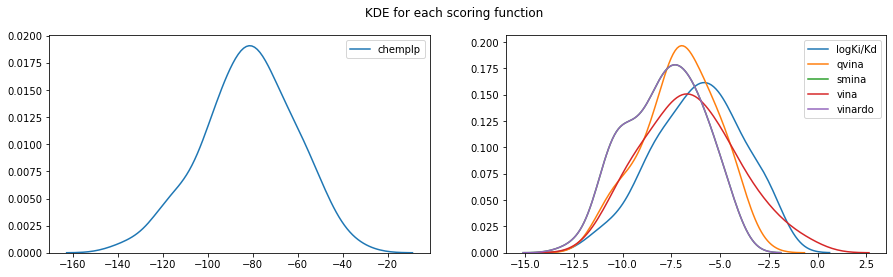

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.kdeplot(data_clean['chemplp'],ax=ax[0])
for i, f in enumerate(data.columns[2:]):
    sns.kdeplot(data_clean[f],ax=ax[1])
plt.suptitle('KDE for each scoring function')

Text(0.5, 1, 'Spearman')

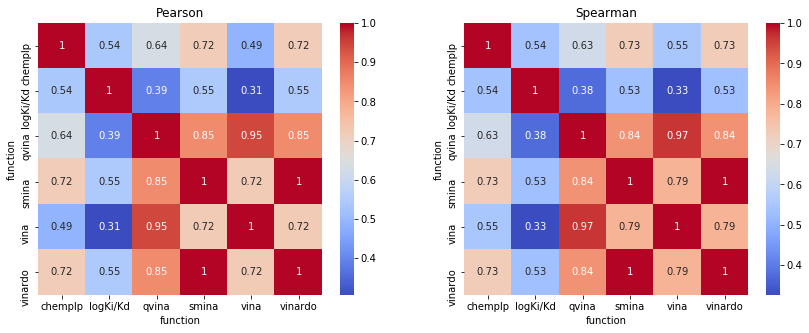

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(data_clean.corr(method='pearson') , annot=True, cmap='coolwarm', ax=ax[0]).set_title('Pearson')
sns.heatmap(data_clean.corr(method='spearman'), annot=True, cmap='coolwarm', ax=ax[1]).set_title('Spearman')